In [5]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [7]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2026-01-06 19:00:52--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   216MB/s    in 0.3s    

2026-01-06 19:00:52 (216 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
# 3

batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
                                            directory=train_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42
                                        )
val_data_gen = validation_image_generator.flow_from_directory(
                                            directory=validation_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42
                                        )
test_data_gen = test_image_generator.flow_from_directory(
                                            directory=PATH,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            classes=['test'],
                                            shuffle=False,
                                            seed=42
                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


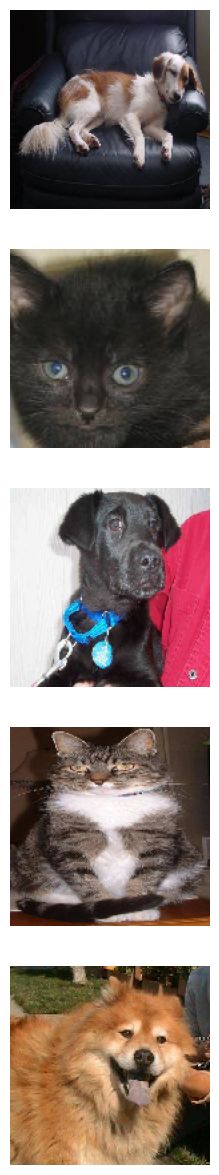

In [9]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [10]:
# 5
train_image_generator = ImageDataGenerator(rotation_range=15,
                                           shear_range=0.1,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           rescale=1./255
                                           )

Found 2000 images belonging to 2 classes.


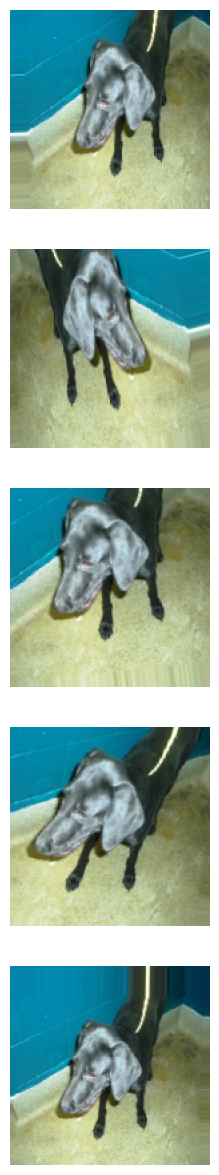

In [11]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [12]:
# 7
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.5
num_labels = 2

model = Sequential()
model.add(Conv2D(filters=16,
                  kernel_size=kernel_size,
                  activation='relu',
                  input_shape=input_shape)
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=32,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=64,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=128,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add( Dense(1, activation='sigmoid') )

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,513 (3.44 MB)

 Trainable params: 900,513 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 8
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [14]:
step_size_train=train_data_gen.n//train_data_gen.batch_size
step_size_valid=val_data_gen.n//val_data_gen.batch_size

# Stopping condition
callback = EarlyStopping(monitor='val_loss',
                                  mode="min",
                                  patience=3,
                                  restore_best_weights=True)

history = model.fit(train_data_gen,
                    epochs=epochs,
                    steps_per_epoch=step_size_train,
                    batch_size=batch_size,
                    validation_data=val_data_gen,
                    validation_steps=step_size_valid,
                    callbacks=[callback]
                    )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.4931 - loss: 0.7003 - val_accuracy: 0.5725 - val_loss: 0.6898
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.5234 - loss: 0.6905

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5234 - loss: 0.6905 - val_accuracy: 0.5513 - val_loss: 0.6891
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.5443 - loss: 0.6887 - val_accuracy: 0.6239 - val_loss: 0.6685
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 598ms/step - accuracy: 0.6797 - loss: 0.6519 - val_accuracy: 0.6172 - val_loss: 0.6643
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.6053 - loss: 0.6721 - val_accuracy: 0.5848 - val_loss: 0.6685
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5391 - loss: 0.7010 - val_accuracy: 0.6395 - val_loss: 0.6394
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.6321 - loss: 0.6453 - val_accuracy: 0.6105 - val_loss: 0.6480
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - accuracy: 0.5547 - loss: 0.6600 - val_accuracy: 0.6205 - val_loss: 0.6493
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.6354 - loss: 0.6506 - val_accuracy: 0.6652 - val_loss: 0.6

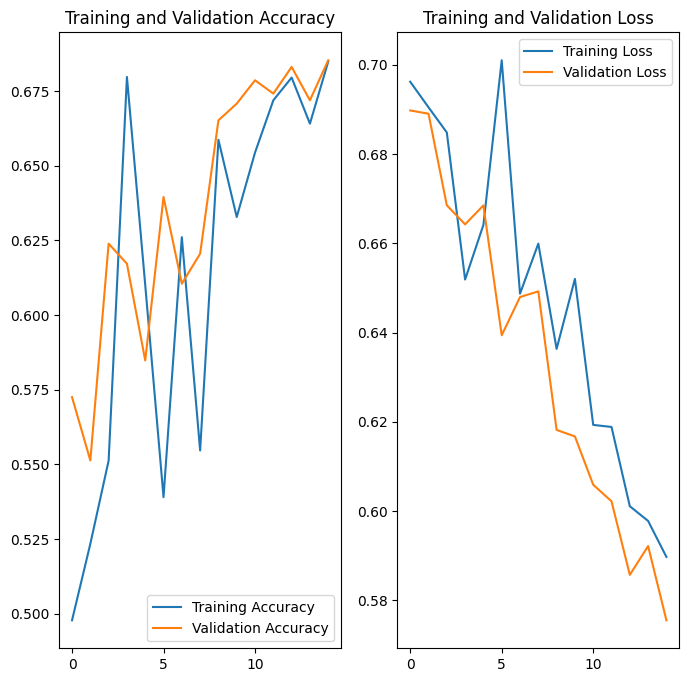

In [15]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


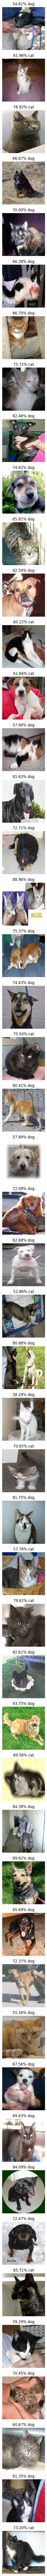

In [17]:

probabilities = model.predict(test_data_gen)
probabilities = probabilities.reshape(-1)
probabilities = probabilities.tolist()

sample_testing_images, _ = next(test_data_gen)
plotImages(sample_testing_images, probabilities = probabilities)


In [18]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
